In [1]:
# Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# just to get rid of all those warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Goal

The goal of this exploration is to create an optimal classifier that predicts if inputed Instagram accounts are fake or real. This classifier is built using Logistic Regression Models. I will make use of both a baseline Linear Regression Model and a hyperparameter tuned linear regression model to classify unseen accounts as real or fake.

# Data Exploration

Link to Dataset: https://www.kaggle.com/free4ever1/instagram-fake-spammer-genuine-accounts?select=test.csv

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ig_train.csv')
train_df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [4]:
train_df.columns

Index(['profile pic', 'nums/length username', 'fullname words',
       'nums/length fullname', 'name==username', 'description length',
       'external URL', 'private', '#posts', '#followers', '#follows', 'fake'],
      dtype='object')

In [4]:
# rename columns to omit whitespace
new_cols = {'profile pic': 'profile_pic', 'nums/length username': 'acc_name_ratio', 'fullname words': 'fullname_words',
       'nums/length fullname': 'fullname_ratio', 'name==username':'name_match', 'description length':'bio_len',
       'external URL':'URL_flag', 'private':'private_flag', '#posts':'post_nums', '#followers':'follower_nums', '#follows':'follow_nums', 'fake':'fake_flag'}

train_df.rename(columns=new_cols, inplace=True)
train_df.head()

,profile_pic,acc_name_ratio,fullname_words,fullname_ratio,name_match,bio_len,URL_flag,private_flag,post_nums,follower_nums,follow_nums,fake_flag
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [6]:
# To understand the scale of our dataset
train_df.shape

(576, 12)

In [ ]:
train_df.isna().sum()

profile_pic       0
acc_name_ratio    0
fullname_words    0
fullname_ratio    0
name_match        0
bio_len           0
URL_flag          0
private_flag      0
post_nums         0
follower_nums     0
follow:nums       0
fake_flag         0
dtype: int64

We have no null values in this dataset. Cleaning will be a lot simpler.

In [63]:
train_df.fake_flag.value_counts()

1    288
0    288
Name: fake_flag, dtype: int64

The number of observations in each classifcation match too.

### Exploration of Binary Features

In [7]:
# find columns that are binary
binary_features = [feature for feature in train_df.columns if len(train_df[feature].unique()) == 2]
binary_features

['profile_pic', 'name_match', 'URL_flag', 'private_flag', 'fake_flag']

In [8]:
# Drop fake flag as binary feature feature
binary_features = binary_features[:-1]

In [ ]:
# sum of binary variables/number of obervations in class for real and fake accounts
bin_dist = train_df.groupby(by=train_df.fake_flag)[binary_features].sum()/train_df.groupby(by=train_df.fake_flag)[binary_features].count()
bin_dist

,profile_pic,name_match,URL_flag,private_flag
fake_flag,,,,
0,0.993056,0.003472,0.232639,0.395833
1,0.409722,0.065972,0.000000,0.368056


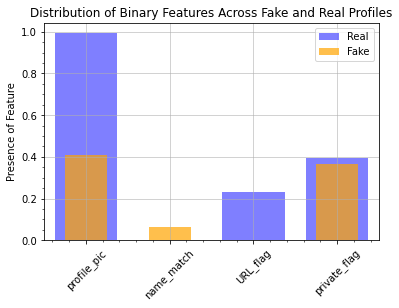

In [ ]:
# visualization of ratio of binary features
ax = bin_dist.iloc[0].plot(kind='bar', color='blue', width=.75, legend=True, alpha=0.5)
bin_dist.iloc[1].plot(kind='bar', color='orange', width=.5, alpha=0.7, legend=True)

plt.ylabel("Presence of Feature")
plt.grid(which='major', alpha=0.7)
plt.minorticks_on()
plt.legend(["Real", "Fake"], loc='upper right')
plt.xticks(rotation=45)

plt.title("Distribution of Binary Features Across Fake and Real Profiles")
plt.show()

Surprisingly, it looks like the presence of a URL is indicative of a real account

### Exploration of Other Features

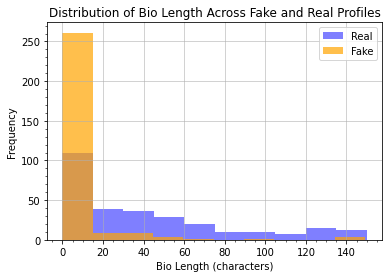

In [ ]:
# Look at description length across real and fake profiles
desc_dist_real = train_df.loc[train_df.fake_flag == 0].bio_len.copy()
desc_dist_fake = train_df.loc[train_df.fake_flag == 1].bio_len.copy()

ax = desc_dist_real.plot(kind='hist', color='blue', legend=True, alpha=0.5)
desc_dist_fake.plot(kind='hist', color='orange', alpha=0.7, legend=True)

plt.ylabel("Frequency")
plt.xlabel("Bio Length (characters)")
plt.grid(which='major', alpha=0.7)
plt.minorticks_on()
plt.legend(["Real", "Fake"], loc='upper right')

plt.title("Distribution of Bio Length Across Fake and Real Profiles")
plt.show()

In [ ]:
# Look at followers distribution across real and fake profiles
follower_dist_real = train_df.loc[train_df.fake_flag == 0].follower_nums.copy()
follower_dist_fake = train_df.loc[train_df.fake_flag == 1].follower_nums.copy()

# Assessing the range for the two account types
print("Range for real account followers: {:,}".format(follower_dist_real.max() - follower_dist_real.min()))
print("Range for fake account followers: {:,}".format(follower_dist_fake.max() - follower_dist_fake.min()))

Range for real account followers: 15,338,529
Range for fake account followers: 3,033


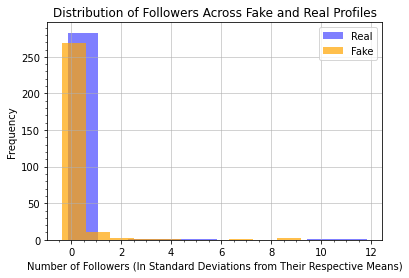

Mean Followers of Real Accounts: 170,504
Mean Followers of Fake Accounts: 111


In [ ]:
# As the difference in  range for these  columns is large, we standardize the data
follower_dist_real_scaled =(follower_dist_real - follower_dist_real.mean())/(follower_dist_real.std())
follower_dist_fake_scaled = (follower_dist_fake - follower_dist_fake.mean())/(follower_dist_fake.std())

ax = follower_dist_real_scaled.plot(kind='hist', color='blue', legend=True, alpha=0.5)
follower_dist_fake_scaled.plot(kind='hist', color='orange', alpha=0.7, legend=True)

plt.ylabel("Frequency")
plt.xlabel("Number of Followers (In Standard Deviations from Their Respective Means)")
plt.grid(which='major', alpha=0.7)
plt.minorticks_on()
plt.legend(["Real", "Fake"], loc='upper right')

plt.title("Distribution of Followers Across Fake and Real Profiles")
plt.show()
print("Mean Followers of Real Accounts: {:,.0F}".format(follower_dist_real.mean()))
print("Mean Followers of Fake Accounts: {:.0F}".format(follower_dist_fake.mean()))

Mean followers for real accounts seems high. We must consider the data collection process of this dataset as it appears that the dataset may not be represent the population well.

In [ ]:
# Look at following distribution across real and fake profiles
follow_dist_real = train_df.loc[train_df.fake_flag == 0].follow_nums.copy()
follow_dist_fake = train_df.loc[train_df.fake_flag == 1].follow_nums.copy()

# Assessing the range for the two account types
print("Range for real account follows: {:,}".format(follow_dist_real.max() - follow_dist_real.min()))
print("Range for fake account follows: {:,}".format(follow_dist_fake.max() - follow_dist_fake.min()))

Range for real account follows: 7,500
Range for fake account follows: 7,272


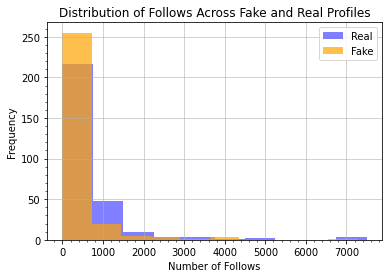

Mean Follows of Real Accounts: 715
Mean Follows of Fake Accounts: 302


In [ ]:
# As the range for total follows is similar to each other, we don't need to scale

ax = follow_dist_real.plot(kind='hist', color='blue', legend=True, alpha=0.5)
follow_dist_fake.plot(kind='hist', color='orange', alpha=0.7, legend=True)

plt.ylabel("Frequency")
plt.xlabel("Number of Follows")
plt.grid(which='major', alpha=0.7)
plt.minorticks_on()
plt.legend(["Real", "Fake"], loc='upper right')

plt.title("Distribution of Follows Across Fake and Real Profiles")
plt.show()
print("Mean Follows of Real Accounts: {:,.0F}".format(follow_dist_real.mean()))
print("Mean Follows of Fake Accounts: {:,.0F}".format(follow_dist_fake.mean()))

In [9]:
# Look at following distribution across real and fake profiles
post_dist_real = train_df.loc[train_df.fake_flag == 0].post_nums.copy()
post_dist_fake = train_df.loc[train_df.fake_flag == 1].post_nums.copy()

# Assessing the range for the two account types
print("Range for real account posts: {:,}".format(post_dist_real.max() - post_dist_real.min()))
print("Range for fake account posts: {:,}".format(post_dist_fake.max() - post_dist_fake.min()))

Range for real account posts: 7,389
Range for fake account posts: 299


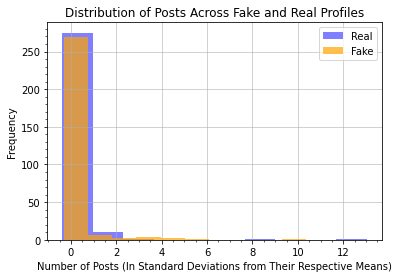

Mean Posts of Real Accounts: 206
Mean Posts of Fake Accounts: 9


In [10]:
# As the difference in  range for these  columns is large, we sarndardize the data
post_dist_real_scaled =(post_dist_real - post_dist_real.mean())/(post_dist_real.std())
post_dist_fake_scaled = (post_dist_fake - post_dist_fake.mean())/(post_dist_fake.std())

ax = post_dist_real_scaled.plot(kind='hist', color='blue', legend=True, alpha=0.5)
post_dist_fake_scaled.plot(kind='hist', color='orange', alpha=0.7, legend=True)

plt.ylabel("Frequency")
plt.xlabel("Number of Posts (In Standard Deviations from Their Respective Means)")
plt.grid(which='major', alpha=0.7)
plt.minorticks_on()
plt.legend(["Real", "Fake"], loc='upper right')

plt.title("Distribution of Posts Across Fake and Real Profiles")
plt.show()
print("Mean Posts of Real Accounts: {:,.0F}".format(post_dist_real.mean()))
print("Mean Posts of Fake Accounts: {:,.0F}".format(post_dist_fake.mean()))

Similar to number of followers, the mean posts also seems high. 

# Implemetation of Logistic Regression to Determine Profile Type

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

In [6]:
# As all datapoints are numeric, no data encoding is required

# Split output and training data
train_outputs = train_df.fake_flag
train_df.pop('fake_flag')

0      0
1      0
2      0
3      0
4      0
      ..
571    1
572    1
573    1
574    1
575    1
Name: fake_flag, Length: 576, dtype: int64

In [7]:
def evaluate(model, X, y_true):
    '''
    Calculates the accuracy for a trained logistic regression model
    
    Parameters:
    model: Trained Linear Regression Model
    X, pandas.DataFrame -- test/validation input
    y_true, pandas.dataFrame, numpy.nparray -- real output for X
    
    Returns:
    accuracy, float -- accuracy of the model on passed data
    auc, float -- Area under the ROC (score for model performance)
    '''
    
    # Calculate predicted values
    y_pred = model.predict(X)

    correct = 0

    # if predicted val matches real val, increase correct
    for i, pred in enumerate(y_pred):
      if pred == y_true.iloc[i]:
        correct += 1

    # Calculate accuracy
    accuracy = (correct / y_true.shape[0]) * 100

    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred)
    
    return accuracy, auc

Note: In this situation, the accuracy and the AUC are roughly the same. This is because the number of observation in each class for the training set is the same.

### Implementation of a Baseline Logistic Regression Classifier

In [8]:
# Initialise test data
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ig_test.csv')
test_df.rename(columns=new_cols, inplace=True)

test_outputs = test_df.fake_flag
test_df.pop('fake_flag')

0      0
1      0
2      0
3      0
4      0
      ..
115    1
116    1
117    1
118    1
119    1
Name: fake_flag, Length: 120, dtype: int64

In [9]:
# Initialize and Fit Model
model = LogisticRegression()
model.fit(train_df, train_outputs)

# Obtain Evaluation Metrics
acc, auc = evaluate(model, test_df, test_outputs)

print('Model AUC: {:2f}'.format(auc))

Model AUC: 0.908333


Text(0.5, 1.0, 'Predicting Fake Instagram Accounts')

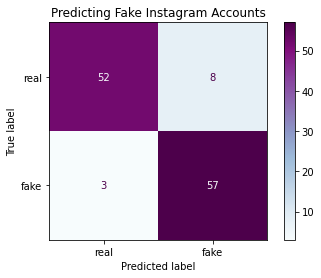

In [48]:
y_pred = model.predict(test_df)

# Plotting confusion matrix for model outputs
labels = ["real", "fake"]
plot_confusion_matrix(model, test_df, test_outputs, display_labels=labels, cmap='BuPu')
plt.title("Predicting Fake Instagram Accounts")

#### Feature Importance for Baseline Model

In [55]:
# feature weights
weights = model.coef_[0]

# Dataframe storing feature name and it's assigned weight
feat_importance = pd.DataFrame([train_df.columns, weights]).T
# Rename Columns
feat_importance.rename(columns={0:'Feature', 1:'Weight'}, inplace=True)
# Sort from highest weight to lowest and display
feat_importance = feat_importance.sort_values(by='Weight', ascending=False, key=abs)
feat_importance.reset_index(drop=True, inplace=True)

display(feat_importance)

,Feature,Weight
0,acc_name_ratio,3.34628
1,profile_pic,-2.95199
2,private_flag,-0.976308
3,fullname_ratio,0.806112
4,name_match,0.75261
5,URL_flag,-0.746025
6,fullname_words,-0.478901
7,post_nums,-0.0140987
8,bio_len,-0.0120212
9,follower_nums,-0.0026903


### Logistic Regression Classifier After Tuning

In [49]:
# A Validation set is needed because we want to tune our LRM's hyperparameters depending on the AUC on the validation set
x_train, x_valid, y_train, y_valid = train_test_split(train_df, train_outputs, test_size=0.2, random_state=0)

In [20]:
# The model is tuned using penalty_types, and C_values

In [50]:
def tune_logistic_regression(X_train, y_train, X_valid, y_valid, penalty_types, C_values, verbose=True):
    '''Tunes logistic regression models over the hyperparameters penalty type and C
       to maximize the accuracy of the models
       
       Paarameters:
       X_train: pandas.DataFrame -- Input for training data
       y_train: pandas.DataFrame, numpy.nparray -- Output for training data
       X_valid: pandas.DataFrame -- Input for validation data
       y_valid: pandas.DataFrame, numpy.nparray -- Output for validation data
       penalty_types, str -- norm tpye ('l1', 'l2')
       C_values, numpy.nparray, list(int) -- Regularization Strength

       Returns:
       best_model: sklearn.LinearRegression -- Trained model with the best AUC
       parameters: dict -- dictionary of the best parameters
       val_aucs, numpy.nparray -- array holding the AUC of every model
       '''

    # Create empty lists where we will store the results of hyperparameter tuning 
    parameters = []
    models = []
    val_aucs = []
    
    # Loop through the hyperparameters of interest
    for penalty in penalty_types:
        for C in C_values:
            
            # Train the logistic regression model with the given hyperparameters
            lr = LogisticRegression(C=C, penalty=penalty, solver='liblinear')
    
            # Fit the model using the training data
            lr = lr.fit(X_train, y_train)
            
            # Get the evalution metrics on the validation set 
            acc, auc  = evaluate(lr, X_valid, y_valid)         
            
            # Store the results
            parameters.append({'penalty': penalty, 'C': C})
            models.append(lr)
            val_aucs.append(auc)

            print('--'*20, '\nModel Parameters:\nPenalty: {}, C: {} '.format(penalty, C))
            print('Model AUC: {:2f}'.format(auc))
            
    
    # Determine the best model -- that is, the one with the greatest AUC
    best_model_index = np.argmax(val_aucs)
    best_model = models[best_model_index]
    
    print('- - '*10,"\nBest model parameters: ", parameters[best_model_index])
    print("Best model AUC: ", val_aucs[best_model_index])
    
    # Return best model
    return best_model, parameters, val_aucs

In [51]:
penalty_types=["l1", "l2"]
C_values=[0.01, 0.1, 1, 10, 100, 1000]

final_model, params_list, aucs = tune_logistic_regression(x_train, y_train, x_valid, y_valid, penalty_types, C_values, verbose=True)

---------------------------------------- 
Model Parameters:
Penalty: l1, C: 0.01 
Model AUC: 0.724138
---------------------------------------- 
Model Parameters:
Penalty: l1, C: 0.1 
Model AUC: 0.870690
---------------------------------------- 
Model Parameters:
Penalty: l1, C: 1 
Model AUC: 0.922414
---------------------------------------- 
Model Parameters:
Penalty: l1, C: 10 
Model AUC: 0.913793
---------------------------------------- 
Model Parameters:
Penalty: l1, C: 100 
Model AUC: 0.913793
---------------------------------------- 
Model Parameters:
Penalty: l1, C: 1000 
Model AUC: 0.913793
---------------------------------------- 
Model Parameters:
Penalty: l2, C: 0.01 
Model AUC: 0.732759
---------------------------------------- 
Model Parameters:
Penalty: l2, C: 0.1 
Model AUC: 0.732759
---------------------------------------- 
Model Parameters:
Penalty: l2, C: 1 
Model AUC: 0.732759
---------------------------------------- 
Model Parameters:
Penalty: l2, C: 10 
Model AUC: 0.

It is important to note that the performance above is only on the validation set. The reason we measure AUC for the validation set is to see what parameters work best for this situation prior to exposing our model to test data. Now that we have the ideal model and parameters, we can assess the performance of our model on the test data

In [52]:
acc, auc = evaluate(final_model, test_df, test_outputs)

print('Model AUC: {:2f}'.format(auc))

Model AUC: 0.891667


Text(0.5, 1.0, 'Predicting Fake Instagram Accounts')

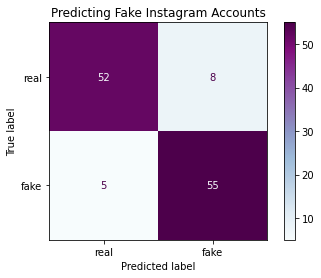

In [54]:
y_pred = final_model.predict(test_df)

# Plotting confusion matrix for model outputs
labels = ["real", "fake"]
plot_confusion_matrix(final_model, test_df, test_outputs, display_labels=labels, cmap='BuPu')
plt.title("Predicting Fake Instagram Accounts")

#### Feature Importance for Best Tuned Model

In [56]:
# feature weights
weights = final_model.coef_[0]

# Dataframe storing feature name and it's assigned weight
feat_importance2 = pd.DataFrame([train_df.columns, weights]).T
# Rename Columns
feat_importance2.rename(columns={0:'Feature', 1:'Weight'}, inplace=True)
# Sort from highest weight to lowest and display
feat_importance2 = feat_importance2.sort_values(by='Weight', ascending=False, key=abs)
feat_importance2.reset_index(drop=True, inplace=True)

display(feat_importance2)

,Feature,Weight
0,acc_name_ratio,6.32608
1,profile_pic,-2.86889
2,URL_flag,-1.71138
3,name_match,1.2862
4,fullname_words,-0.24888
5,private_flag,-0.170155
6,post_nums,-0.0173395
7,bio_len,-0.00745825
8,follower_nums,-0.00207805
9,follow_nums,0.00100328


### Evaluation

While the best tuned model works very well on the validation set, the baseline model performs better overall on the test set. This is interesting because one would expect that models that have been tuned would procure the most accuraate predictions.

One possible reason for this is that we do not have an extensive training sample. As the training set consists of just 576 observations, splitting that down into training and validation could result in an underfitting of training data for the models that are tuned. Therefore, these models are not as generalizable. 

## Possible Extensions to the Project

I might try bootstrapping training data to get a larger training sample and make the output more generalizable. I believe that a Bootstrapped Aggeragate could help combat this issue of underfitting and provide a more robust classifier